<a href="https://colab.research.google.com/github/Barbozah/ProcessamentoDeImagens/blob/master/ProjetoPI_Futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import multiprocessing as mp
!pip install cython
%load_ext Cython

In [0]:
def randrect(img):
    p = list(np.random.randint(0, img.shape[1], 2)) + list(np.random.randint(0, img.shape[0], 2))
    return cv2.rectangle(img, 
                         (min(p[0], p[2]), min(p[1], p[3])), 
                         (max(p[0], p[2]), max(p[1], p[3])),
                         255, cv2.FILLED)

def dice(img, p1, p2, color, value):
    img = img[:]
    w, h = p2[0]-p1[0], p2[1]-p1[1]
    img = cv2.rectangle(img, p1, p2, color=color, thickness=cv2.FILLED)
    img = cv2.rectangle(img, p1, p2, color=[255,255,255], thickness=1)
    pos = [
        [(1,1)],
        [(0,0),(2,2)],
        [(0,0),(1,1),(2,2)],
        [(0,0),(2,0),(0,2),(2,2)],
        [(0,0),(2,0),(1,1),(0,2),(2,2)],
        [(0,0),(2,0),(0,1),(2,1),(0,2),(2,2)]
    ][value-1]
    _h15 = int(h*.15)
    _w15 = int(w*.15)
    _h3 = int(h*.3)
    _w3 = int(w*.3)
    _h45 = int(h*.45)
    _w45 = int(w*.45)
    _h6 = int(h*.6)
    _w6 = int(w*.6)
    _h75 = int(h*.75)
    _w75 = int(w*.75)
    _h9 = int(h*.9)
    _w9 = int(w*.9)
    shape = img[p1[1]+_h15:p1[1]+_h3,p1[0]+_w15:p1[0]+_w3].shape
    if (0,0) in pos:
        img[p1[1]+_h15:p1[1]+_h3,p1[0]+_w15:p1[0]+_w3] = np.ones(shape) # 0,0
    if (1,0) in pos:
        img[p1[1]+_h15:p1[1]+_h3,p1[0]+_w45:p1[0]+_w6] = np.ones(shape) # 1,0
    if (2,0) in pos:
        img[p1[1]+_h15:p1[1]+_h3,p1[0]+_w75:p1[0]+_w9] = np.ones(shape) # 2,0
    if (0,1) in pos:
        img[p1[1]+_h45:p1[1]+_h6,p1[0]+_w15:p1[0]+_w3] = np.ones(shape) # 0,1
    if (1,1) in pos:
        img[p1[1]+_h45:p1[1]+_h6,p1[0]+_w45:p1[0]+_w6] = np.ones(shape) # 1,1
    if (2,1) in pos:
        img[p1[1]+_h45:p1[1]+_h6,p1[0]+_w75:p1[0]+_w9] = np.ones(shape) # 2,1
    if (0,2) in pos:
        img[p1[1]+_h75:p1[1]+_h9,p1[0]+_w15:p1[0]+_w3] = np.ones(shape) # 0,2
    if (1,2) in pos:
        img[p1[1]+_h75:p1[1]+_h9,p1[0]+int(w*.45):p1[0]+_w6] = np.ones(shape) # 1,2
    if (2,2) in pos:
        img[p1[1]+_h75:p1[1]+_h9,p1[0]+_w75:p1[0]+_w9] = np.ones(shape) # 2,2
    return img

def randcoord(w, h):
    return np.random.randint(0, w-10), np.random.randint(0, h-10)

def manhattan_distance(p1, p2):
    return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

def inside(xy, square):
    return square[0] <= xy[0] <= square[2] and square[1] <= xy[1] <= square[3]

def inside_list(el, _list, arg=None):
    check = False
    for l in _list:
        if not arg:
            if inside(el, l):
                return True
        else:
            if inside(el, l+arg):
                return True
    return False

def minkowski_distance(p1, p2, p=4):
    return ( abs(p1[0]-p2[0])**p + abs(p1[1]-p2[1])**p )**(1/p)

def euclidean_distance(p1, p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**(1/2)
  
def closer(el, nodes, distance):
    c = (float('inf'), float('inf'))
    for i in nodes:
        if float(distance(i, el).real) < float(distance(c, el).real):
            c = i
    return c

def grow(img, dices, distance):
    new_img = img.copy()
    for i in range(len(img)):
        for j in range(len(img[i])):
            if sum(img[i][j]) == 0:
                coords = map(lambda x: (x[0]+10, x[1]+10), list(dices.keys()))
                c = closer((j,i), coords, distance)
                c = (c[0]-10, c[1]-10)
                new_img[i][j] = dices[c][1]
    return new_img

def apply_rand_dices(shape_img=(400,400,3), num_dices=5, size_dice=(20,20), colors=None):
    if not colors:
        colors=[[240,0,0],[0,240,0],[0,0,240],[240,240,0],[240,0,240],[0,240,240]]
    m = np.zeros(shape_img)
    dices = {}
    for i in range(num_dices):
        coord = randcoord(m.shape[0]-size_dice[0], m.shape[1]-size_dice[1])
        while inside_list(coord, list(dices.keys()), size_dice):
            coord = randcoord(m.shape[0]-size_dice[0], m.shape[1]-size_dice[1])
        value = np.random.randint(1,6)
        dices[coord] = (value, colors[value-1])
        m = dice(m, coord, (coord[0]+size_dice[0], coord[1]+size_dice[1]), colors[value-1], value)
    return m, dices

In [0]:
%%cython
def grow_cython(img, dices, distance):
  new_img = img.copy()
  for i in range(len(img)):
      for j in range(len(img[i])):
          if sum(img[i][j]) == 0:
              coords = map(lambda x: (x[0]+10, x[1]+10), list(dices.keys()))
              def closer(el, nodes, distance):
                c = (float('inf'), float('inf'))
                for i in nodes:
                    if float(distance(i, el).real) < float(distance(c, el).real):
                        c = i
                return c
              c = closer((j,i), coords, distance)
              c = (c[0]-10, c[1]-10)
              new_img[i][j] = dices[c][1]
  return new_img

In [0]:
%%cython

import multiprocessing as mp

def inter_w(tup):
    j, i, img, dices, distance = tup
    if sum(img[i][j]) == 0:
        coords = map(lambda x: (x[0]+10, x[1]+10), list(dices.keys()))
        def closer(el, nodes, distance):
          c = (float('inf'), float('inf'))
          for i in nodes:
              if float(distance(i, el).real) < float(distance(c, el).real):
                  c = i
          return c
        c = closer((j,i), coords, distance)
        c = (c[0]-10, c[1]-10)
        return dices[c][1]
    return img[i][j]

def inter_h(tup):
    i, img, dices, distance = tup
    w = [(j, i, img, dices, distance) for j in range(len(img[i]))]
    return list(map(inter_w, w))

def grow_mp(img, dices, distance):
  p = mp.Pool(16)
  h = [(i, img, dices, distance) for i in range(len(img))]
  return p.map(inter_h, h)

In [0]:
%%cython

from multiprocessing.pool import ThreadPool

def inter_w(tup):
    j, i, img, dices, distance = tup
    if sum(img[i][j]) == 0:
        coords = map(lambda x: (x[0]+10, x[1]+10), list(dices.keys()))
        def closer(el, nodes, distance):
          c = (float('inf'), float('inf'))
          for i in nodes:
              if float(distance(i, el).real) < float(distance(c, el).real):
                  c = i
          return c
        c = closer((j,i), coords, distance)
        c = (c[0]-10, c[1]-10)
        return dices[c][1]
    return img[i][j]

def inter_h(tup):
    i, img, dices, distance = tup
    w = [(j, i, img, dices, distance) for j in range(len(img[i]))]
    return list(map(inter_w, w))

def grow_thread(img, dices, distance):
  h = [(i, img, dices, distance) for i in range(len(img))]
  pool = ThreadPool(processes=len(h))
  async_results = [pool.apply_async(map, (inter_h, h)) for r in range(len(img))]
  return [[*r.get()] for r in async_results]

In [0]:
%%time
img, dices = apply_rand_dices(num_dices=7)
g = grow(img, dices, minkowski_distance)

CPU times: user 3.73 s, sys: 1.51 ms, total: 3.73 s
Wall time: 3.74 s


In [0]:
%%time
img, dices = apply_rand_dices(num_dices=7)
g = grow_cython(img, dices, minkowski_distance)

CPU times: user 3.1 s, sys: 2.85 ms, total: 3.11 s
Wall time: 3.11 s


In [0]:
import time
import progressbar

def grow_with_progress(img, dices, distance):
    new_img = img.copy()
    widgets=[
      '[', progressbar.Timer(), '] ',
      progressbar.Bar(),
      ' (', progressbar.ETA(), ') ',
    ]
    for i in progressbar.progressbar(range(len(img)), widgets=widgets):
      for j in range(len(img[i])):
        if sum(img[i][j]) == 0:
          coords = map(lambda x: (x[0]+10, x[1]+10), list(dices.keys()))
          c = closer((j,i), coords, distance)
          c = (c[0]-10, c[1]-10)
          new_img[i][j] = dices[c][1]
    return new_img

img, dices = apply_rand_dices(num_dices=7)

g = grow_with_progress(img, dices, minkowski_distance)

[Elapsed Time: 0:00:03] |###################################| (Time:  0:00:03) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


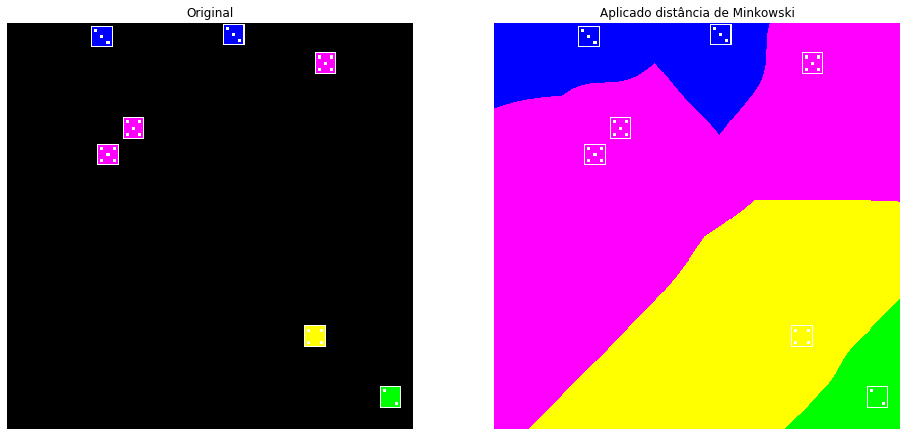

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(g)
ax[1].set_title('Aplicado distância de Minkowski')
ax[1].set_axis_off()